In [2]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from scipy.signal import butter, sosfiltfilt, filtfilt, freqz
from scipy import signal
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d
import pickle
from skimage import io, filters
import glob
from contextlib import contextmanager
import sys
import psutil
import json
import warnings
warnings.filterwarnings("ignore")
from shutil import copyfile

/home/users/ilanazs/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [3]:
fly_num = 'fly_208'
func_path = f'/oak/stanford/groups/trc/data/Ilana/2P/data/{fly_num}/'
load_directory = os.path.join(func_path, 'func_0/background_subtraction/functional_channel_2_moco.h5')
# save_directory = os.path.join(func_path, 'func_0/background_subtraction/functional_channel_2_moco_highpass_test.h5')
# load_directory = os.path.join(func_path, 'func_0/functional_channel_2_moco_zscore.h5')
load_directory

'/oak/stanford/groups/trc/data/Ilana/2P/data/fly_208/func_0/background_subtraction/functional_channel_2_moco.h5'

In [4]:
%%time

with h5py.File(load_directory, 'r') as hf:
        data = hf['data'][:] 
#         print("Data shape is {}".format(dims))

CPU times: user 0 ns, sys: 5.61 s, total: 5.61 s
Wall time: 48.9 s


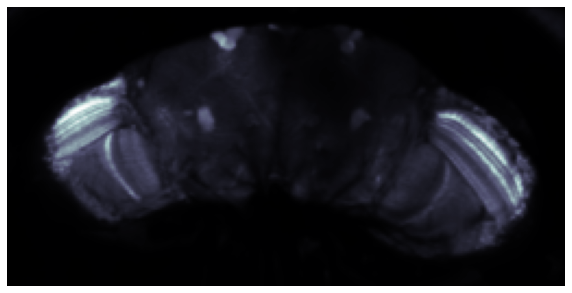

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(np.mean(data[:,:,20,:],axis=-1).T, cmap='bone')
plt.axis('off');

In [6]:
warp_dir = os.path.join(func_path, 'warp')
f2a = ants.image_read(os.path.join(warp_dir, 'func-to-anat.nii'))
anat_dir = os.path.join(func_path, 'anat_0', 'moco')
anat = ants.image_read(os.path.join(anat_dir, 'anatomy_channel_1_moc_mean.nii'))
anat_clean = ants.image_read(os.path.join(anat_dir, 'anatomy_channel_1_moc_mean_clean.nii'))
res_anat = (0.653, 0.653, 1)
anat.set_spacing(res_anat)
anat_rs = ants.resample_image(anat,(2,2,2),use_voxels=False)
anat_clean.set_spacing(res_anat)
anat_rs_clean = ants.resample_image(anat_clean,(2,2,2),use_voxels=False)

In [7]:
anat

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (1024, 512, 241)
	 Spacing    : (0.653, 0.653, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

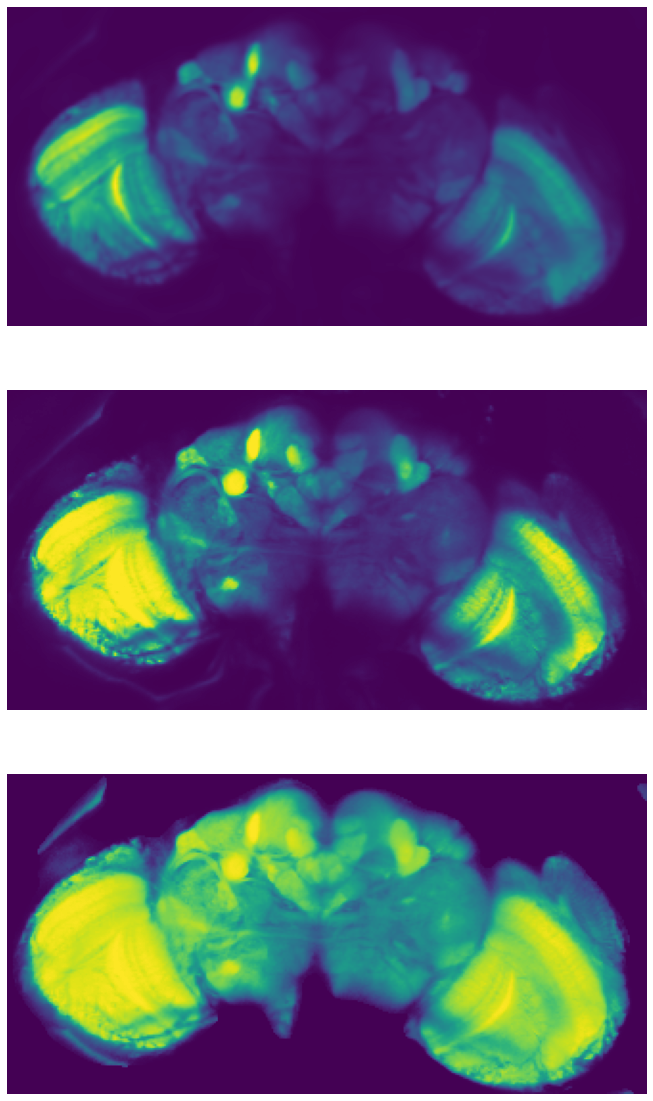

In [8]:
z=70
plt.figure(figsize=(20,20))
plt.subplot(3,1,1)
plt.imshow(f2a[:,:,z].T)
plt.axis('off');
plt.subplot(3,1,2)
plt.imshow(anat_rs[:,:,z].T)
plt.axis('off');
plt.subplot(3,1,3)
plt.imshow(anat_rs_clean[:,:,z].T)
plt.axis('off');

In [9]:
fda = ants.image_read("/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20220301_luke_2_jfrc_affine_zflip_2umiso.nii")
a2a = ants.image_read(os.path.join(warp_dir, 'anat-to-meanbrain.nii'))
anat_low=anat.resample_image((2,2,2),use_voxels=False)
np.shape(a2a)

(314, 146, 91)

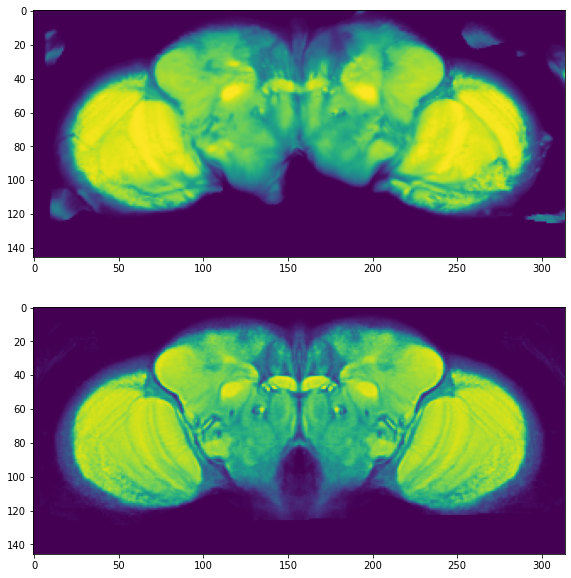

In [10]:
z=20
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(a2a[:,:,z].T)
plt.subplot(2,1,2)
plt.imshow(fda[:,:,z].T)

In [11]:
np.shape(fda)

(314, 146, 91)

In [12]:
##func2anat##
func=True
# ##anat2atlas##
# func=False
if func:
    moving_path = os.path.join(func_path, "func_0", "moco", "functional_channel_1_moc_mean.nii")
    fixed_path = os.path.join(func_path, "anat_0", "moco", "anatomy_channel_1_moc_mean.nii")
    res = (0.653, 0.653, 1)
    grad_step = 0.2
    flow_sigma = 3
    total_sigma = 0
    syn_sampling = 32
    type_of_transform = "Affine"
else:
    moving_path = os.path.join(func_path, "anat_0","moco","anatomy_channel_1_moc_mean_clean.nii")
    fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20220301_luke_2_jfrc_affine_zflip_2umiso.nii"
    res = (2, 2, 2)
    grad_step = 0.2
    flow_sigma = 3
    total_sigma = 0
    syn_sampling = 32
    type_of_transform = "SyN"

In [13]:
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res)
fixed = ants.resample_image(fixed,(2,2,2),use_voxels=False)


In [14]:
moving = np.asarray(nib.load(moving_path).get_data().squeeze(), dtype='float32')
moving = ants.from_numpy(moving)
moving.set_spacing(res)
moving = ants.resample_image(moving,(2,2,2),use_voxels=False)

In [15]:
@contextmanager
def stderr_redirected(to=os.devnull):

    fd = sys.stderr.fileno()

    def _redirect_stderr(to):
        sys.stderr.close() # + implicit flush()
        os.dup2(to.fileno(), fd) # fd writes to 'to' file
        sys.stderr = os.fdopen(fd, 'w') # Python writes to fd

    with os.fdopen(os.dup(fd), 'w') as old_stderr:
        with open(to, 'w') as file:
            _redirect_stderr(to=file)
        try:
            yield # allow code to be run with the redirected stdout
        finally:
            _redirect_stderr(to=old_stderr) # restore stdout.
                                            # buffering and flags such as
                                            # CLOEXEC may be different


In [16]:
#  with stderr_redirected(): # to prevent dumb itk gaussian error bullshit infinite printing
moco = ants.registration(fixed,
                         moving,
                         type_of_transform=type_of_transform,
                         grad_step=grad_step, 
                         flow_sigma=flow_sigma,
                         total_sigma=total_sigma,
                         syn_sampling=syn_sampling)


In [17]:
print(moco)

{'warpedmovout': ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (334, 167, 121)
	 Spacing    : (2.0, 2.0, 2.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]
, 'warpedfixout': ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (84, 42, 25)
	 Spacing    : (2.0, 2.0, 2.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]
, 'fwdtransforms': ['/tmp/tmpmy12rh660GenericAffine.mat'], 'invtransforms': ['/tmp/tmpmy12rh660GenericAffine.mat']}


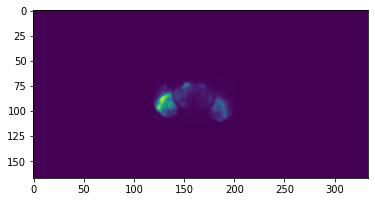

In [18]:
img=moco['warpedmovout']
res_anat = (0.653, 0.653, 1)
img.set_spacing(res_anat)
plt.imshow(img[...,70].T)

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(img[:,:,z].T)

TypeError: Cannot slice image objects; consider using `img.slicer[slice]` to generate a sliced image (see documentation for caveats) or slicing image array data with `img.dataobj[slice]` or `img.get_fdata()[slice]`

<Figure size 720x720 with 0 Axes>